<a href="https://colab.research.google.com/github/koivunen/beamdefectdetect_dt2/blob/main/damage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a demo on detecting steel beam defects 

### Guide
 1. Choose runtime instance from top menu: Runtime -> Change Runtime Type. Change it to GPU as seen below:
 
   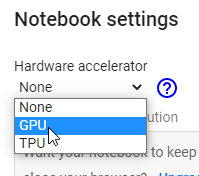
 2. Press the play buttons on each code cell below one after another. Also follow instructions before each code cell. 
    
    You may also need to check the results for signs of errors. 
    
    Wait for each cell to finish before proceeding to the next!


### 1. Installation
This cell will install dependencies. Check output for errors and proceed after it has finished.

Due to installation, the system running this notebook will be restarted. Due to this you have to one time ignore the error "*Your session crashed for an unknown reason.*" Make sure the output does not say *FAILED TO INSTALL DETECTRON*


In [ ]:
!pip install --quiet pyyaml==5.1
!wget --no-clobber -q --show-progress "https://seafile.utu.fi/f/cf91e875424b476cade8/?dl=1" -O weights.pth # beam_damage_detectron2_2022-2-23.pth
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

restart_runtime=False
try:
  import detectron2
except ImportError as e:
  restart_runtime=True
!pip install --quiet detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
if restart_runtime:
  exit(0)
try:
  import detectron2
except ImportError as e:
  print("FAILED TO INSTALL DETECTRON")
  exit(0)

# 2. Upload the detection file
Upload the video you want to run detection on. It should be low FPS (10fps preferably) and low resolution (320x240 - 1024x768) for speed.
As a demo you can use for example: https://seafile.utu.fi/f/1cbd6551d4fe402b9903/?dl=1

In [ ]:
from google.colab import files
uploaded = files.upload()
video_name = next(iter(uploaded.keys()))

# 3. Setup detection
This will set up the detection system.

In [ ]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

MetadataCatalog.get("damage_train").set(thing_classes=["damage"])

damage_metadata = MetadataCatalog.get("damage_train")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TRAIN = ("damage_train",)
cfg.DATASETS.TEST = ("damage_train",)
cfg.TEST.DETECTIONS_PER_IMAGE = 20
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512) #TODO: Verify for car+beam
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  


#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = 'weights.pth'
predictor = DefaultPredictor(cfg)

# 4. Run detection
This will run the detection on the file you uploaded.
 **You can view progress and progress bar below along with predicted time remaining.** The image shown is close to the most confident detection.
 This will take anything from minutes to hours!

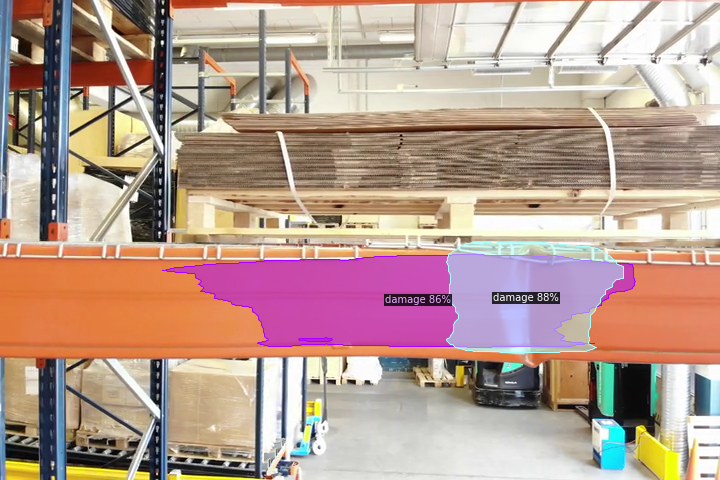

 Damage 76% confidence @ 0:00:14: 100%|██████████| 139/139 [01:01<00:00,  2.25it/s]


In [ ]:
import cv2,tqdm
import datetime
from time import time as Now
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.video_visualizer import VideoVisualizer

from detectron2.utils.visualizer import ColorMode
from IPython.display import clear_output 




# From https://stackoverflow.com/a/62446532

video = cv2.VideoCapture(video_name)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
assert frames_per_second<40,"fps too high, will take forever"
assert num_frames/frames_per_second<60,"video is over a minute long, will take forever"
assert width<1920,"video size is too large, will take forever"
assert height<1080,"video size is too large, will take forever"
print("Video info: w=",width," h=",height," fps=",frames_per_second," frames=",num_frames," seconds=",num_frames/frames_per_second)
max_frames = num_frames
#max_frames = 60
last_show_frame=0

out_filename = video_name+'.detect.mp4'
video_writer = cv2.VideoWriter(out_filename, fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)

v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)

def detect(video, maxFrames):
 
    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break
        outputs = predictor(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        data = outputs["instances"].to("cpu")
        visualization = v.draw_instance_predictions(frame, data)
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
        yield (visualization,data,readFrames)
        readFrames += 1
        if readFrames > maxFrames:
            break

conf_increasing=0

pbar=tqdm.tqdm(detect(video, min(max_frames,num_frames)), total=max_frames)
for visualization,data,fnum in pbar:
#for visualization,outputs,fnum in detect(video, min(max_frames,num_frames)):
    video_writer.write(visualization)
    scores=data.scores.tolist()
    detection=False
    if len(scores)>0:
      conf=round(max(scores)*100)
      if conf_increasing<conf:
        conf_increasing=conf
        detection=True
      #detection=conf>0.5

    if detection and Now()-last_show_frame>8:
      last_show_frame=Now()
      clear_output()
      cv2_imshow(visualization)

    if len(scores)>0:
      conf=round(max(scores)*100)
      s=fnum/frames_per_second
      txt=" Damage "+str(conf)+"% confidence @ "+str(datetime.timedelta(seconds=int(s)))
      pbar.set_description(txt, refresh=True)

# Release resources
video.release()
video_writer.release()
cv2.destroyAllWindows()

# 5. Download results video

For now only a video is outputted instead of bookmarks

In [ ]:
from google.colab import files
files.download(out_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>